In [1]:
import fluxy as fl
from influxdb_client.client.influxdb_client_async import InfluxDBClientAsync
from dotenv import load_dotenv
import os
from datetime import datetime, timezone, timedelta
import pandas as pd 
import seaborn as sns 
import matplotlib.dates as mdates
import matplotlib.pylab as plt 
import numpy as np

load_dotenv()

API_TOKEN = os.getenv("ANALYSIS_API_TOKEN")

In [2]:
start = datetime.now(timezone.utc) - timedelta(days=14)
stop = datetime.now(timezone.utc)

In [3]:
from pandas import DataFrame


async def submit_query(fl) -> DataFrame:
  async with InfluxDBClientAsync("https://influxdb.prod.power-hub.foundationzero.org", API_TOKEN, "power_hub") as client:
    print(fl.to_flux())
    return await client.query_api().query_data_frame(fl.to_flux())
  
from typing import Any

async def get_data(
    sensors_to_query: list[Any],
    query_range: tuple[datetime, datetime],
    resolution: timedelta,
    windowoperation: fl.WindowOperation,
) -> pd.DataFrame:

    query = fl.pipe(
        fl.from_bucket("power_hub"),
        fl.range(*query_range),
        fl.filter(fl.any(fl.conform, sensors_to_query)),
        fl.aggregate_window(resolution, windowoperation, False),
        fl.keep(["_time", "_value", "_field"]),
        fl.pivot(["_time"], ["_field"], "_value"),
    )

    
    df = await submit_query(query)
    df = df.drop(columns = ["result","table"]).set_index("_time",drop = True).sort_index()
    df.index = df.index.tz_convert('Europe/Madrid')
    
    return df

## We want to see what's up with the Yazaki performance. 

- Note that the error output of the Yazaki is always set to True 


In [161]:
power_variables = ["yazaki_used_power","yazaki_chill_power","yazaki_waste_power"]
temp_variables = ["rh33_yazaki_hot_hot_temperature","rh33_waste_hot_temperature","rh33_chill_cold_temperature", "pcm_temperature"]
flow_variables = ["yazaki_hot_flow", "yazaki_waste_flow", "yazaki_chilled_flow"]
status_variables = ["yazaki_operation_output","yazaki_error_output","pcm_to_yazaki_pump_on"]

window_size = timedelta(minutes = 1)

In [162]:
powers = await get_data([{"_field": variable} for variable in power_variables], (start, stop), window_size, fl.WindowOperation.MEAN)
flows = await get_data([{"_field": variable} for variable in flow_variables], (start, stop), window_size, fl.WindowOperation.MEAN)
temperatures = await get_data([{"_field": variable} for variable in temp_variables], (start, stop), window_size, fl.WindowOperation.MEAN)
statusses = await get_data([{"_field": variable} for variable in status_variables], (start, stop), window_size, fl.WindowOperation.LAST)
control_modes = await get_data([{"_field": "chill_control"}], (start, stop), window_size, fl.WindowOperation.LAST)

from(bucket: "power_hub")
|> range(start: 2024-08-27T09:43:56.997955+00:00, stop: 2024-09-10T09:43:56.997976+00:00)
|> filter(fn: (r) => r["_field"] == "yazaki_used_power" or r["_field"] == "yazaki_chill_power" or r["_field"] == "yazaki_waste_power")
|> aggregateWindow(every: 60s, fn: mean, createEmpty: false)
|> keep(columns: ["_time", "_value", "_field"])
|> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
from(bucket: "power_hub")
|> range(start: 2024-08-27T09:43:56.997955+00:00, stop: 2024-09-10T09:43:56.997976+00:00)
|> filter(fn: (r) => r["_field"] == "yazaki_hot_flow" or r["_field"] == "yazaki_waste_flow" or r["_field"] == "yazaki_chilled_flow")
|> aggregateWindow(every: 60s, fn: mean, createEmpty: false)
|> keep(columns: ["_time", "_value", "_field"])
|> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
from(bucket: "power_hub")
|> range(start: 2024-08-27T09:43:56.997955+00:00, stop: 2024-09-10T09:43:56.997976+00:00)
|> filter(fn: (r) 

In [163]:
df = pd.concat([powers,flows,temperatures,statusses, control_modes], axis = 1)

In [164]:
def isolate_runs(data: pd.DataFrame, window_size: timedelta):
    
    run_indices = np.split(data.index,np.where(data.index.diff()>window_size)[0])
    
    return [data.loc[run_index] for run_index in run_indices]
    

### Flow rates (https://drive.google.com/drive/folders/1-xGdoO2oBvKA1k_ezFCkquOQFcPdWaFG)
- Rated chill flow: .77
- Rated waste flow: 2.55
- Rated heat flow: 1.20 

We see that the hot flow can be doubled, the others are OK 

In [165]:
df[df['chill_control'].str.contains('chill_yazaki').fillna(False)][flow_variables].mean()

/var/folders/w7/x3ddjmps2dvfqdrygwzccnd00000gn/T/ipykernel_98763/4220207356.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[df['chill_control'].str.contains('chill_yazaki').fillna(False)][flow_variables].mean()


yazaki_hot_flow        0.528341
yazaki_waste_flow      2.632133
yazaki_chilled_flow    0.824171
dtype: float64

### Temperatures (https://drive.google.com/drive/folders/1-xGdoO2oBvKA1k_ezFCkquOQFcPdWaFG)
- chill in: 12.5
- waste in: 31 
- hot in: 88

hot temp is on the cold side. Currently regulated with PID - can get rid of it. 

In [166]:
df[df['chill_control'].str.contains('chill_yazaki').fillna(False)][temp_variables].mean()

/var/folders/w7/x3ddjmps2dvfqdrygwzccnd00000gn/T/ipykernel_98763/112298990.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[df['chill_control'].str.contains('chill_yazaki').fillna(False)][temp_variables].mean()


rh33_yazaki_hot_hot_temperature    76.793492
rh33_waste_hot_temperature         29.113108
rh33_chill_cold_temperature        10.435158
pcm_temperature                    79.118761
dtype: float64

## Check out individual runs

In [167]:
yazaki_on = df['chill_control'].str.contains('yazaki').fillna(False)
runs = isolate_runs(df[yazaki_on], timedelta(minutes = 1))

/var/folders/w7/x3ddjmps2dvfqdrygwzccnd00000gn/T/ipykernel_98763/1546818797.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yazaki_on = df['chill_control'].str.contains('yazaki').fillna(False)


_time
2024-08-27 14:59:00+02:00    prepare_chill_yazaki
2024-08-27 15:00:00+02:00    prepare_chill_yazaki
2024-08-27 15:01:00+02:00     check_yazaki_bounds
2024-08-27 15:02:00+02:00            chill_yazaki
2024-08-27 15:03:00+02:00            chill_yazaki
Name: chill_control, dtype: object
_time
2024-08-28 13:46:00+02:00    prepare_chill_yazaki
2024-08-28 13:47:00+02:00    prepare_chill_yazaki
2024-08-28 13:48:00+02:00     check_yazaki_bounds
2024-08-28 13:49:00+02:00            chill_yazaki
2024-08-28 13:50:00+02:00            chill_yazaki
Name: chill_control, dtype: object
_time
2024-08-29 13:32:00+02:00    prepare_chill_yazaki
2024-08-29 13:33:00+02:00    prepare_chill_yazaki
2024-08-29 13:34:00+02:00     check_yazaki_bounds
2024-08-29 13:35:00+02:00            chill_yazaki
2024-08-29 13:36:00+02:00            chill_yazaki
Name: chill_control, dtype: object
_time
2024-08-29 14:40:00+02:00    prepare_chill_yazaki
2024-08-29 14:41:00+02:00    prepare_chill_yazaki
2024-08-29 14:42:00+0

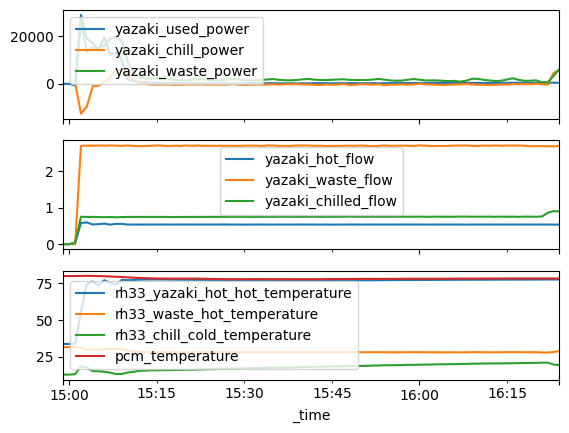

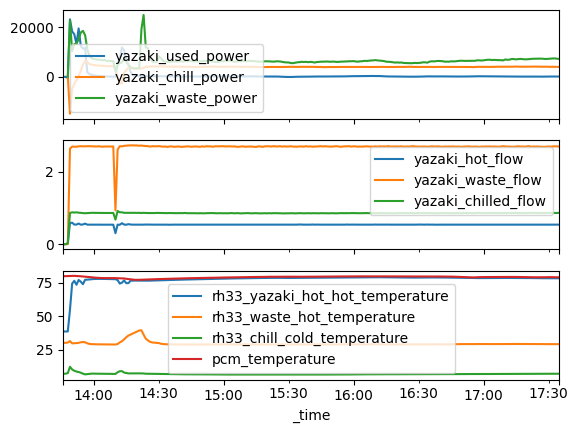

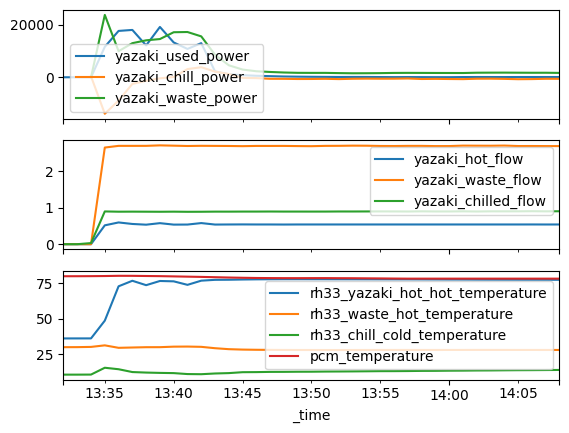

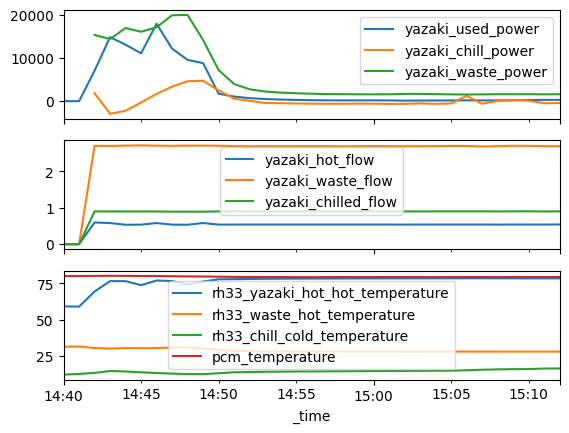

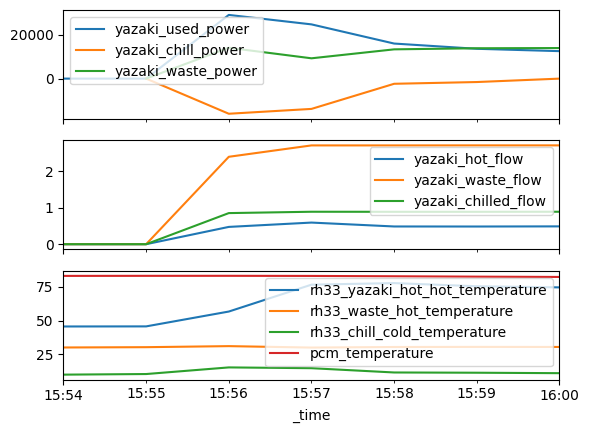

In [168]:
for run in runs:
    fig, axs = plt.subplots(nrows = 3, sharex = True)
    print(run['chill_control'].head(5))
    run[power_variables].plot(ax = axs[0])
    run[flow_variables].plot(ax = axs[1])
    run[temp_variables].plot(ax = axs[2])
    

# Setpoints 
- PCM charged at 83 seems really high - it seems to max out around 80 
- PCM discharged at 75 also seems high, as Yazaki would still be able to do something 
- The yazaki hot inlet is PID'd at 75 (which is the same as the PCM discharge temp). We can just get rid of this PID for now to see hwat Yazaki does with the hottest possible temp. 
- The bound of 3000W chill power for 5 mins is clearly too strict for the Yazaki at this moment. Let's give it some more space to see what's going on 